In [ ]:
%load_ext autoreload
%autoreload 2
exec(open('init_notebook.py').read())
from matplotlib import pyplot as plt
from highD.HighD import HighD
from highD.Filter import Filter
from highD.Plot import Plot
from highD.Visualizer import GIF
from highD.helper import *

In [63]:

import os

def read_cogmod_files(file_names, COGMOD_LOGS):
    dfs = []
    for file_name in file_names:
        cogmod_file_path = os.path.join(COGMOD_LOGS, file_name)
        df = pd.read_csv(cogmod_file_path)
        dfs.append(df)
    return dfs

file_names = ["2023-05-28-18-42-01---0.csv",
              "2023-05-28-18-57-59---0.csv"]    
cogmod_dfs = read_cogmod_files(file_names, COGMOD_LOGS)
print(cogmod_dfs[0].columns)
# cogmod_dfs[0].head()
# Plot.plot_individual_exec_nums(cogmod_dfs[-1])
# Plot.plot_individual_exec_nums(cogmod_dfs[-1], from_start=True)
# Plot.plot_individual_exec_nums(cogmod_dfs[0], only_running=True)
print(cogmod_dfs[0]['exec_num'].unique())

grouped = cogmod_dfs[0].groupby('exec_num')

# for name, group in grouped:
#     group = group[group['scenario_status'] == 'ScenarioState.RUNNING']
#     print(name, len(group))

# print('cogmod')
# grouped = cogmod_dfs[1].groupby('exec_num')
# for name, group in grouped:
#     group = group[group['scenario_status'] == 'ScenarioState.RUNNING']
#     print(name, len(group))


Index(['scenario_id', 'exec_num', 'frame', 'scenario_status', 'ego_id', 'c_x',
       'c_y', 'c_speed', 'c_acceleration', 'target_speed', 'c_steer',
       'c_throttle', 'c_brake', 'perceived_c_x', 'perceived_c_y',
       'perceived_c_speed', 'gaze_direction', 'preceding_id', 'a_x', 'a_y',
       'a_speed'],
      dtype='object')
[10  9  8  7  6  5  4  3  2  1  0]
0 218
1 218
2 218
3 218
4 218
5 218
6 218
7 218
8 218
9 218
10 218
cogmod
0 218
1 218
2 218
3 218
4 218
5 218
6 218
7 218
8 218
9 218
10 218


In [ ]:
Plot.plot_all_exec_nums(cogmod_dfs[0])
Plot.plot_all_exec_nums(cogmod_dfs[-1])

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_ttc_idm(df, cMin, cMax, exec_no=0):
    
    # Calculate distance between ego vehicle and preceding vehicle
    distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)

    # Calculate relative speed between ego vehicle and preceding vehicle
    relative_speed = df['c_speed'] - df['a_speed']

    # Avoid division by zero when calculating TTC
    relative_speed = np.where(relative_speed != 0, relative_speed, 1e-6)
    
    # Calculate TTC
    ttc = distance / relative_speed

    # add a new column named 'ttc' to the dataframe
    df['ttc'] = ttc
    
    # selecting only the relevant scene/frame
    df = df[df['scenario_status'] == 'ScenarioState.RUNNING']
    
    # selecting only the relevant execution
    df = df[df['exec_num'] == exec_no]

    return df

def calculate_ttc_cogmod(df, cMin, cMax):
    
    # Calculate distance between ego vehicle and preceding vehicle
    distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)

    # Calculate relative speed between ego vehicle and preceding vehicle
    relative_speed = df['c_speed'] - df['a_speed']

    # Avoid division by zero when calculating TTC
    relative_speed = np.where(relative_speed != 0, relative_speed, 1e-6)

    # Calculate TTC
    ttc = distance / relative_speed
    
    df['ttc'] = ttc
    
    # best exec is with lowest ttc
    best_exec = df[df['ttc'] == ttc.min()]['exec_num'].values[0]
    
    # selecting only the relevant scene/frame
    df = df[df['scenario_status'] == 'ScenarioState.RUNNING']
    
    print('best exec ', best_exec)
    # selecting only the relevant execution
    df = df[df['exec_num'] == best_exec]

    return df

def calculate_thw_idm(df, cMin, cMax, exec_no=0):
    
    # df = df[df['scenario_status'] != 'ScenarioState.PENDING']
    # Calculate distance between ego vehicle and preceding vehicle
    distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)

    # time cogmod vehicle requires to reach the preceding vehicle at current speed
    # current speed, V; distance to preceding vehicle, d; time, t = d/V
    # Calculate relative speed between ego vehicle and preceding vehicle
    thw = distance / df['c_speed']
    
    df['thw'] = thw
    
    print(df.columns)
    
    # selecting only the relevant scene/frame
    df = df[df['scenario_status'] == 'ScenarioState.RUNNING']
    
    # selecting only the relevant execution
    df = df[df['exec_num'] == exec_no]
    
    return df

def calculate_thw_cogmod(df, cMin, cMax):
    
    # df = df[df['scenario_status'] != 'ScenarioState.PENDING']
    # Calculate distance between ego vehicle and preceding vehicle
    distance = np.sqrt((df['c_x'] - df['a_x'])**2 + (df['c_y'] - df['a_y'])**2)

    # time cogmod vehicle requires to reach the preceding vehicle at current speed
    # current speed, V; distance to preceding vehicle, d; time, t = d/V
    # Calculate relative speed between ego vehicle and preceding vehicle
    thw = distance / df['c_speed']
    
    df['thw'] = thw
    
    # selecting only the relevant scene/frame
    df = df[df['scenario_status'] == 'ScenarioState.RUNNING']
    
    best_exec = df[df['thw'] == thw.min()]['exec_num'].values[0]
    print('best exec ', best_exec)
    # selecting only the relevant execution
    df = df[df['exec_num'] == best_exec]
    
    return df


def calculate_ttc(tracks, follow_meta, cMin, cMax):
    # Calculate distance between ego vehicle and preceding vehicle
    ego_id = follow_meta['ego_id']
    start_frame = follow_meta['start_frame']
    end_frame = follow_meta['end_frame']

    # Get the relevant tracks for the scenario
    ego_tracks = tracks.loc[(tracks['id'] == ego_id) & (tracks['frame'] >= start_frame) & (tracks['frame'] < end_frame)]

    # Calculate TTC for ego vehicle
    ttc_ego = ego_tracks['ttc'].values
    
    ttc_ego = ttc_ego[ttc_ego < cMax]
    ttc_ego = ttc_ego[ttc_ego > cMin]
    
    return ttc_ego

def calculate_thw(tracks, follow_meta, cMin, cMax):
    # Calculate distance between ego vehicle and preceding vehicle
    ego_id = follow_meta['ego_id']
    start_frame = follow_meta['start_frame']
    end_frame = follow_meta['end_frame']

    # Get the relevant tracks for the scenario
    ego_tracks = tracks.loc[(tracks['id'] == ego_id) & (tracks['frame'] >= start_frame) & (tracks['frame'] < end_frame)]

    # Calculate TTC for ego vehicle
    thw_ego = ego_tracks['thw'].values
    
    thw_ego = thw_ego[thw_ego < cMax]
    thw_ego = thw_ego[thw_ego > cMin]
    
    return thw_ego





In [ ]:
ids = ["01", "02"]
highD = HighD(ids, DATA_DIRECTORY)

dataset_id = 1
_, tMeta, tracks = highD.get_dataframe_tuple(dataset_id)
df = highD.get_combined_dataframe(dataset_id)
image = highD.get_image(dataset_id)

In [ ]:
follow_meta = Filter.filter_vehicle_follow_scenario(df, 
                                      ego_type='Car', 
                                      preceding_type='Car',
                                      minDuration=5, 
                                      minStartDistance=50,
                                      maxStartDistance=100,
                                      removeStrictDistanceInc=True)

print(follow_meta.shape)
follow_meta.head()

In [61]:
scenario_id = 0
print('scenario id ', scenario_id)
scenario_follow_meta = follow_meta.iloc[scenario_id]
ego_id = int(scenario_follow_meta['ego_id'])
preceding_id = int(scenario_follow_meta['preceding_id'])
start_frame = int(scenario_follow_meta['start_frame'])
end_frame = int(scenario_follow_meta['end_frame'])
print(ego_id, preceding_id, start_frame, end_frame)
print('total frmae ', end_frame - start_frame)

scenario id  0
50 47 994 1211
total frmae  217


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ttc(tracks, follow_meta, cMin, cMax):
    # Extract information about the scenario from the follow_meta dataframe
    ego_id = follow_meta['ego_id']
    start_frame = follow_meta['start_frame']
    end_frame = follow_meta['end_frame']

    # Get the relevant tracks for the scenario
    ego_tracks = tracks.loc[(tracks['id'] == ego_id) & (tracks['frame'] >= start_frame) & (tracks['frame'] < end_frame)]

    # Calculate TTC for ego vehicle
    ttc_ego = ego_tracks['ttc'].values

    # Clip TTC values between cMin and cMax
    ttc_ego_clipped = np.clip(ttc_ego, cMin, cMax)

    # Normalize TTC values
    ttc_ego_norm = ttc_ego_clipped 

    # Create a plot
    plt.figure(figsize=(10, 5))

    # Plot TTC distribution
    ttc_ego_clipped = ttc_ego_clipped[ttc_ego_clipped != cMin]
    ttc_ego_clipped = ttc_ego_clipped[ttc_ego_clipped != cMax]
    plt.hist(ttc_ego_clipped, bins=25, edgecolor='black', density=True)
    plt.xlabel('TTC Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of TTC for Ego Vehicle')
    plt.show()


def plot_thw(tracks, follow_meta, cMin, cMax):
    # Extract information about the scenario from the follow_meta dataframe
    ego_id = follow_meta['ego_id']
    start_frame = follow_meta['start_frame']
    end_frame = follow_meta['end_frame']

    # Get the relevant tracks for the scenario
    ego_tracks = tracks.loc[(tracks['id'] == ego_id) & (tracks['frame'] >= start_frame) & (tracks['frame'] < end_frame)]

    # Calculate TTC for ego vehicle
    thw_ego = ego_tracks['thw'].values

    # Clip TTC values between cMin and cMax
    thw_ego_clipped = np.clip(thw_ego, cMin, cMax)

    # Normalize TTC values
    ttc_ego_norm = thw_ego_clipped 

    # Create a plot
    plt.figure(figsize=(10, 5))

    # Plot TTC distribution
    thw_ego_clipped = thw_ego_clipped[thw_ego_clipped != cMin]
    thw_ego_clipped = thw_ego_clipped[thw_ego_clipped != cMax]
    plt.hist(thw_ego_clipped, bins=10, edgecolor='black', density=True)
    plt.xlabel('TTC Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of TTC for Ego Vehicle')
    plt.show()


plot_ttc(df, scenario_follow_meta, 0, 200)
plot_thw(df, scenario_follow_meta, -100, 200)

best exec  10
type  <class 'numpy.ndarray'> (217,)
type  <class 'numpy.ndarray'> (218,)
type  <class 'numpy.ndarray'> (218,)


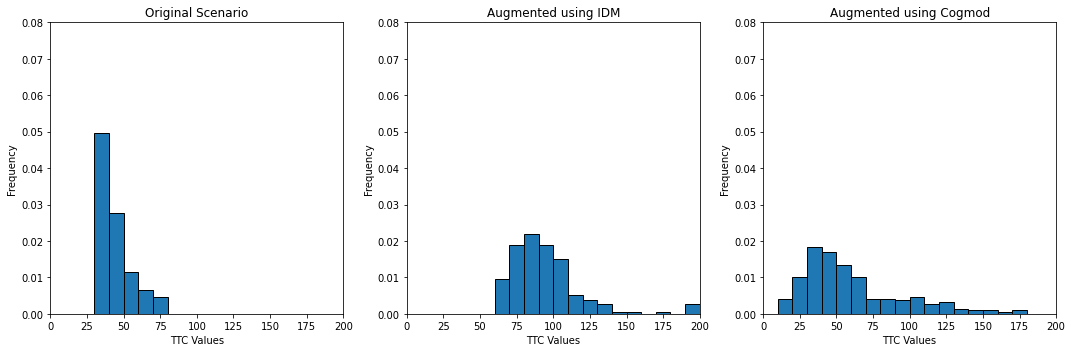

In [116]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ttc_combined(df, follow_meta, df1, df2, cmin, cmax, num_bins=20):
    # Calculate TTCs
    ttc_original = calculate_ttc(df, follow_meta, cmin, cmax)
    ttc_idm = calculate_ttc_idm(df1, cmin, cmax, exec_no=1)
    ttc_cogmod = calculate_ttc_cogmod(df2, cmin, cmax)
    
    ttc_idm = ttc_idm['ttc'].values
    ttc_cogmod = ttc_cogmod['ttc'].values
    
    print('type ', type(ttc_original), ttc_original.shape)
    print('type ', type(ttc_idm), ttc_idm.shape)
    print('type ', type(ttc_cogmod), ttc_cogmod.shape)
    # # Clip TTCs
    ttc_original_clipped = np.clip(ttc_original, cmin, cmax)
    ttc_idm_clipped = np.clip(ttc_idm, cmin, cmax)
    ttc_cogmod_clipped = np.clip(ttc_cogmod, cmin, cmax)
    
    # Calculate maximum x-value for TTCs
    max_ttc = cmax

    # Calculate bin edges based on maximum value
    bin_edges = np.linspace(0, max_ttc, num_bins+1)

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot original scenario
    axs[0].hist(ttc_original_clipped, bins=bin_edges, edgecolor='black', density=True)
    axs[0].set_xlim([0, max_ttc])
    axs[0].set_ylim([0, 0.08])  # Set desired y-axis limits
    axs[0].set_xlabel('TTC Values')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Original Scenario')

    # Plot scenario augmented with IDM
    axs[1].hist(ttc_idm_clipped, bins=bin_edges, edgecolor='black', density=True)
    axs[1].set_xlim([0, max_ttc])
    axs[1].set_ylim([0, 0.08])  # Set desired y-axis limits
    axs[1].set_xlabel('TTC Values')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Augmented using IDM')

    # Plot scenario augmented with Cogmod
    axs[2].hist(ttc_cogmod_clipped, bins=bin_edges, edgecolor='black', density=True)
    axs[2].set_xlim([0, max_ttc])
    axs[2].set_ylim([0, 0.08])  # Set desired y-axis limits
    axs[2].set_xlabel('TTC Values')
    axs[2].set_ylabel('Frequency')
    axs[2].set_title('Augmented using Cogmod')

    plt.tight_layout()
    plt.show()

# Call the function with appropriate parameters
plot_ttc_combined(df, scenario_follow_meta, cogmod_dfs[0], cogmod_dfs[1], 0, 200, num_bins=20)


Index(['scenario_id', 'exec_num', 'frame', 'scenario_status', 'ego_id', 'c_x',
       'c_y', 'c_speed', 'c_acceleration', 'target_speed', 'c_steer',
       'c_throttle', 'c_brake', 'perceived_c_x', 'perceived_c_y',
       'perceived_c_speed', 'gaze_direction', 'preceding_id', 'a_x', 'a_y',
       'a_speed', 'ttc', 'thw'],
      dtype='object')
best exec  8
type  <class 'numpy.ndarray'> (217,)
type  <class 'pandas.core.frame.DataFrame'> (218, 23)
type  <class 'pandas.core.frame.DataFrame'> (218, 23)


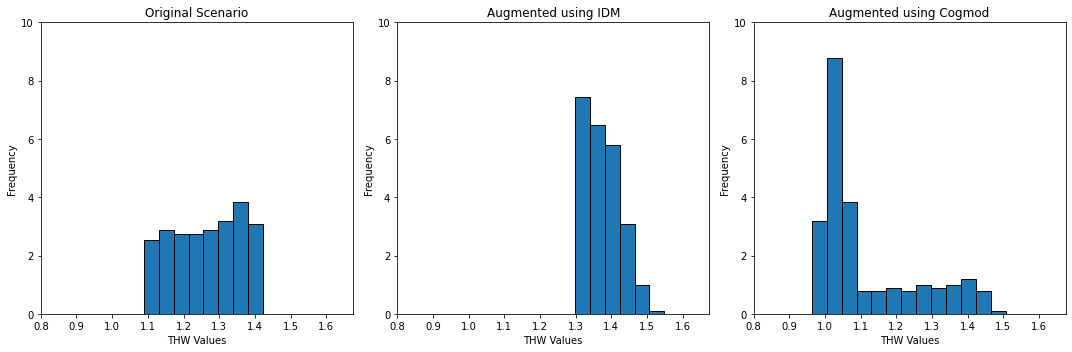

In [114]:
def plot_thw_combined(df, follow_meta, df1, df2, cmin, cmax, num_bins=20):
    # Calculate THWs
    thw_original = calculate_thw(df, follow_meta, cmin, cmax)
    thw_idm = calculate_thw_idm(df1, cmin, cmax, 0)
    thw_cogmod = calculate_thw_cogmod(df2, cmin, cmax)
    
    print('type ', type(thw_original), thw_original.shape)
    print('type ', type(thw_idm), thw_idm.shape)
    print('type ', type(thw_cogmod), thw_cogmod.shape)
    
    max_thw = max(max(thw_original), max(thw_idm['thw']), max(thw_cogmod['thw']))
    max_thw = max_thw + 0.1*max_thw
    
    bin_edges = np.linspace(0, max_thw, num_bins+1)
    # # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # # Plot original scenario
    axs[0].hist(thw_original, bins=bin_edges, edgecolor='black', density=True)
    axs[0].set_xlim([0.8, max_thw])
    axs[0].set_ylim([0, 10])  # Set desired y-axis limits
    axs[0].set_xlabel('THW Values')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Original Scenario')

    # Plot scenario augmented with IDM
    axs[1].hist(thw_idm['thw'], bins=bin_edges, edgecolor='black', density=True)
    axs[1].set_xlim([0.8, max_thw])
    axs[1].set_ylim([0, 10])  # Set desired y-axis limits
    axs[1].set_xlabel('THW Values')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Augmented using IDM')

    # Plot scenario augmented with Cogmod
    axs[2].hist(thw_cogmod['thw'], bins=bin_edges, edgecolor='black', density=True)
    axs[2].set_xlim([0.8, max_thw])
    axs[2].set_ylim([0, 10])  # Set desired y-axis limits
    axs[2].set_xlabel('THW Values')
    axs[2].set_ylabel('Frequency')
    axs[2].set_title('Augmented using Cogmod')

    plt.tight_layout()
    plt.show()

# Call the function with appropriate parameters
plot_thw_combined(df, scenario_follow_meta, cogmod_dfs[0], cogmod_dfs[1], 0, 200, num_bins=40)

In [ ]:
#  nCarFollow 256, filter criteria {'thw_lower_bound': 0, 'thw_upper_bound': 4, 'time_duration': 5, 'distance_threshold': 50}

# def calculate_and_plot_ttc_all(df1, df2, df3=None):
    #     dfs = [df1, df2]

#     fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(10 * len(dfs), 5))

#     for i, df in enumerate(dfs):
#         exec_nums = df['exec_num'].unique()
#         ttc_all = []
#         for exec_num in exec_nums:
#             df_group = df[df['exec_num'] == exec_num]
#             ttc = calculate_ttc(df_group)
#             ttc_all.extend(ttc.tolist())

#         # Plot the distribution of all TTC values
#         axes[i].hist(ttc_all, bins=20, edgecolor='black', density=True)
#         axes[i].set_xlim([0, None])
#         axes[i].set_xlabel('TTC Values')
#         axes[i].set_ylabel('Frequency')
#         axes[i].set_title(f'Distribution of TTC for DataFrame {i+1}')

#     plt.tight_layout()
#     plt.show()

# calculate_and_plot_ttc_all(cogmod_dfs[0], cogmod_dfs[1])